In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Imports 

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary 
import onnx 
import onnxruntime as ort
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error
import random
import os
import datetime
import matplotlib.pyplot as plt

# Dataset Class

In [3]:
class SaliencyDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

## Data Loaders

In [4]:
def get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(256,256),
    split_ratio=(0.8,0.1,0.1),
    batch_sizes=(64,16,16),
    random_state=42
):

    # Collect file lists
    image_files, mask_files = [], []
    for img_dir, msk_dir in zip(image_dirs, mask_dirs):
        imgs = sorted([os.path.join(img_dir,f) for f in os.listdir(img_dir)
                    if f.lower().endswith(('.jpg','.png'))])
        msks = sorted([os.path.join(msk_dir,f) for f in os.listdir(msk_dir)
                    if f.lower().endswith(('.jpg','.png'))])
        assert len(imgs)==len(msks), f"Mismatch in {img_dir}"
        image_files.extend(imgs)
        mask_files.extend(msks)

    # Train/val/test split
    from sklearn.model_selection import train_test_split
    train_ratio, val_ratio, test_ratio = split_ratio
    train_imgs, temp_imgs, train_msks, temp_msks = train_test_split(
        image_files, mask_files, test_size=(1-train_ratio), random_state=random_state)
    val_prop = val_ratio/(val_ratio+test_ratio)
    val_imgs, test_imgs, val_msks, test_msks = train_test_split(
        temp_imgs, temp_msks, test_size=(1-val_prop), random_state=random_state)

    print(f"Total images: {len(image_files)}")
    print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    # Transforms and Dataset
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor()
    ])

    train_ds = SaliencyDataset(train_imgs, train_msks, transform)
    val_ds   = SaliencyDataset(val_imgs,   val_msks,   transform)
    test_ds  = SaliencyDataset(test_imgs,  test_msks,  transform)

    train_loader = DataLoader(train_ds, batch_size=batch_sizes[0], shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_sizes[1], shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=batch_sizes[2], shuffle=False)

    return train_loader, val_loader, test_loader


# Defined Models 

In [5]:
class Saliency_IR_v1(nn.Module):
    def __init__(self):
        super(Saliency_IR_v1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class Saliency_IR_v2(nn.Module):
    def __init__(self):
        super(Saliency_IR_v2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Training Setup

In [7]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

class HybridLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(HybridLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, inputs, targets):
        return self.alpha * self.bce(inputs, targets) + (1 - self.alpha) * self.dice(inputs, targets)


In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=100, log_prefix="exp", device="cuda"):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = f"./training_logs/{log_prefix}_{timestamp}"
    os.makedirs(log_dir, exist_ok=True)

    train_losses, val_losses, lrs = [], [], []
    best_val_loss = float('inf')
    best_model_path = os.path.join(log_dir, "best_model.pth")

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Learning rate tracking
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        if scheduler:
            scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] | LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"  Saved best model at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")

    # Plot losses
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.grid(True)
    plt.savefig(os.path.join(log_dir, "loss_plot.png"))
    plt.show()

    # Optionally save CSV
    with open(os.path.join(log_dir, "loss_log.csv"), "w") as f:
        f.write("epoch,train_loss,val_loss,lr\n")
        for i in range(num_epochs):
            f.write(f"{i+1},{train_losses[i]:.4f},{val_losses[i]:.4f},{lrs[i]:.6f}\n")

    return best_model_path

## Evaluation Setup

In [9]:
def compute_min_pixel_fraction(dataloader, bin_thresh=0.5):
    min_frac = float('inf')
    for _, masks in dataloader:
        m_np = masks.numpy()  # shape (B,1,H,W)
        for m in m_np:
            binary = (m[0] >= bin_thresh).astype(np.uint8)
            total = binary.size
            salient = binary.sum()
            if salient > 0:
                min_frac = min(min_frac, salient/total)
    if min_frac == float('inf'):
        raise RuntimeError("No non-empty masks found.")
    return min_frac

def evaluate_model(
    model,
    dataloader,
    device,
    bin_thresh=0.5,
    area_frac=None,
    compute_area_frac=False,
    beta2=0.3,
    save_model_path=None,
    visualize=False
):
    model.eval()
    if compute_area_frac:
        area_frac = compute_min_pixel_fraction(dataloader, bin_thresh)
        print(f"[INFO] Computed area_frac={area_frac:.6f} from GT masks")

    # Metrics accumulators
    mae_sum = 0
    prec_sum = 0
    rec_sum = 0
    iou_list = []
    y_true, y_pred = [], []
    n = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images).cpu().numpy()
            gts = masks.cpu().numpy()

            for pred, gt in zip(outputs, gts):
                pred = pred[0]; gt = gt[0]
                # MAE
                mae_sum += np.mean(np.abs(pred - gt))
                # Binary masks
                pbin = (pred >= bin_thresh).astype(np.uint8)
                gbin = (gt   >= bin_thresh).astype(np.uint8)
                # Precision/Recall
                tp = (pbin & gbin).sum()
                fp = (pbin & (1-gbin)).sum()
                fn = ((1-pbin) & gbin).sum()
                prec = tp / (tp+fp+1e-8)
                rec  = tp / (tp+fn+1e-8)
                prec_sum += prec; rec_sum += rec
                # IoU
                inter = (pbin & gbin).sum()
                union = (pbin | gbin).sum()
                iou_list.append(inter/union if union>0 else float(inter==0))
                # Object-presence
                def has_obj(mask):
                    return (mask.sum() / mask.size) > area_frac
                y_true.append(has_obj(gbin))
                y_pred.append(has_obj(pbin))

                n += 1

    # Final aggregations
    mae      = mae_sum / n
    precision= prec_sum / n
    recall   = rec_sum / n
    fbeta    = (1+beta2)*precision*recall/(beta2*precision+recall+1e-8)
    miou     = np.mean(iou_list)
    tp_obj   = sum(t and p for t,p in zip(y_true,y_pred))
    fn_obj   = sum(t and not p for t,p in zip(y_true,y_pred))
    obj_recl = tp_obj / (tp_obj+fn_obj+1e-6)

    # Print
    print("\n=== Evaluation Results ===")
    print(f"MAE            : {mae:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"Fβ (β²={beta2}): {fbeta:.4f}")
    print(f"Mean IoU       : {miou:.4f}")
    print(f"Obj Presence R : {obj_recl:.4f}")
    print(f"Binarize thres.: {bin_thresh:.2f}")
    print(f"Area fraction  : {area_frac:.6f}")

    # Optional visualize
    if visualize:
        img, gt_mask = images[0], masks[0][0]
        pred_mask = outputs[0][0]
        fig, axs = plt.subplots(1,3,figsize=(12,4))
        axs[0].imshow(img.permute(1,2,0).cpu());     axs[0].set_title("Image")
        axs[1].imshow(gt_mask.cpu(),cmap='gray');   axs[1].set_title("GT Mask")
        axs[2].imshow(pred_mask,cmap='gray');       axs[2].set_title("Pred Mask")
        plt.show()

    # Optional save model
    if save_model_path:
        torch.save(model.state_dict(), save_model_path)
        print(f"[INFO] Model saved to {save_model_path}")

    return {
        "mae":mae, "precision":precision, "recall":recall,
        "f_beta":fbeta, "miou":miou, "obj_recall":obj_recl,
        "bin_thresh":bin_thresh, "area_frac":area_frac
    }

### 1 - Simulated IR dataset

In [10]:
# Dataset directories:
image_dirs = [
r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/norm_ir_8bit"
]
mask_dirs  = [
r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks"
]

# Get loaders
train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(64,16,16)
)

Total images: 2751
Train: 1925, Val: 413, Test: 413


#### Saliency_IR_v1

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.3584 | Val Loss: 0.1387
  Saved best model at epoch 1 (Val Loss: 0.1387)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.1404 | Val Loss: 0.1246
  Saved best model at epoch 2 (Val Loss: 0.1246)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.1414 | Val Loss: 0.1247
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.1353 | Val Loss: 0.1212
  Saved best model at epoch 4 (Val Loss: 0.1212)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.1307 | Val Loss: 0.1193
  Saved best model at epoch 5 (Val Loss: 0.1193)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.1368 | Val Loss: 0.1206
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.1290 | Val Loss: 0.1161
  Saved best model at epoch 7 (Val Loss: 0.1161)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1244 | Val Loss: 0.1113
  Saved best model at epoch 8 (Val Loss: 0.1113)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.1190 | Val Loss: 0.1042
  Saved best model at epoch 9 (Val Loss: 0.1042)
Epoch [10/100] | LR: 0.001000 | Trai

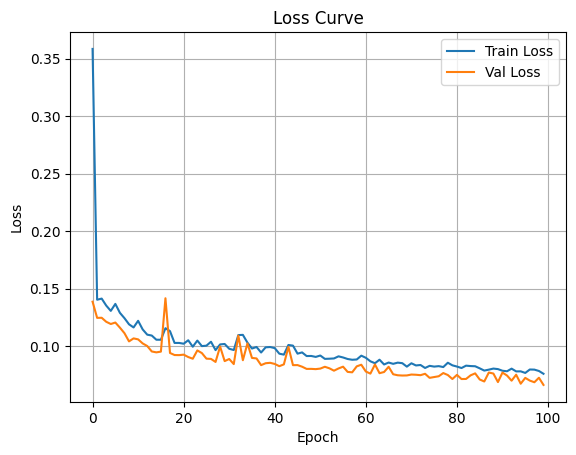


=== Evaluation Results ===
MAE            : 0.0311
Precision      : 0.7551
Recall         : 0.5282
Fβ (β²=0.3): 0.6870
Mean IoU       : 0.4578
Obj Presence R : 0.9894
Binarize thres.: 0.50
Area fraction  : 0.001000


In [11]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, log_prefix="IR_v1_d1_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)

[INFO] Computed area_frac=0.000947 from GT masks

=== Evaluation Results ===
MAE            : 0.0311
Precision      : 0.7551
Recall         : 0.5282
Fβ (β²=0.3): 0.6870
Mean IoU       : 0.4578
Obj Presence R : 0.9894
Binarize thres.: 0.50
Area fraction  : 0.000947


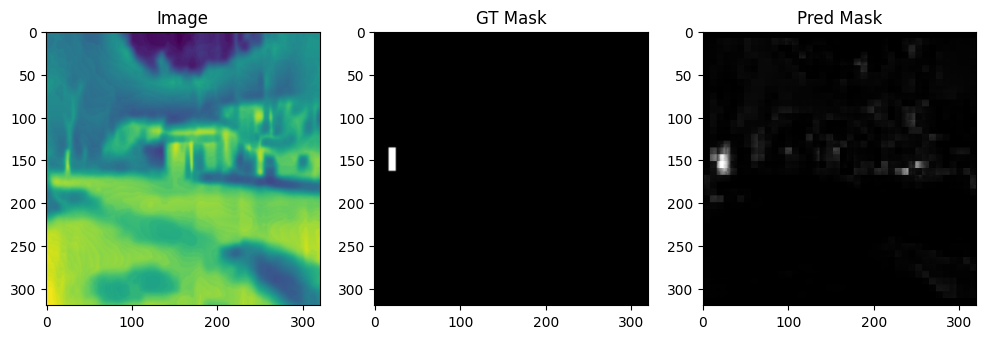

In [12]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=True,
    visualize=True
)

#### Saliency_IR_v2

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.8363 | Val Loss: 0.7360
  Saved best model at epoch 1 (Val Loss: 0.7360)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.5080 | Val Loss: 0.3458
  Saved best model at epoch 2 (Val Loss: 0.3458)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.2534 | Val Loss: 0.1673
  Saved best model at epoch 3 (Val Loss: 0.1673)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.1558 | Val Loss: 0.1316
  Saved best model at epoch 4 (Val Loss: 0.1316)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.1443 | Val Loss: 0.1273
  Saved best model at epoch 5 (Val Loss: 0.1273)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.1381 | Val Loss: 0.1262
  Saved best model at epoch 6 (Val Loss: 0.1262)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.1381 | Val Loss: 0.1257
  Saved best model at epoch 7 (Val Loss: 0.1257)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1362 | Val Loss: 0.1254
  Saved best model at epoch 8 (Val Loss: 0.1254)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.1357 | Val 

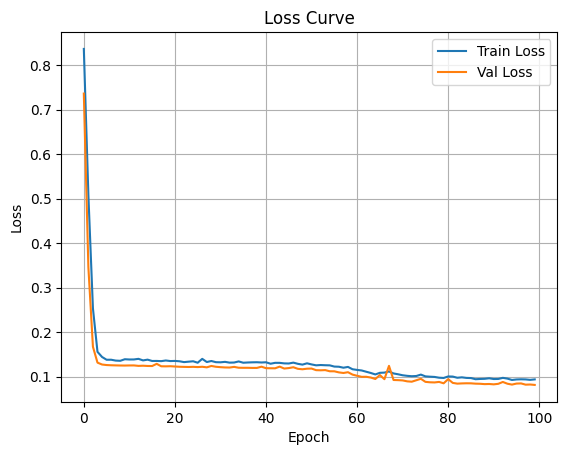


=== Evaluation Results ===
MAE            : 0.0409
Precision      : 0.6761
Recall         : 0.3707
Fβ (β²=0.3): 0.5681
Mean IoU       : 0.3407
Obj Presence R : 0.9096
Binarize thres.: 0.50
Area fraction  : 0.001000


In [13]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, log_prefix="IR_v2_d1_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.0932 | Val Loss: 0.0813
  Saved best model at epoch 1 (Val Loss: 0.0813)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.0940 | Val Loss: 0.0811
  Saved best model at epoch 2 (Val Loss: 0.0811)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.0911 | Val Loss: 0.0817
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.0916 | Val Loss: 0.0809
  Saved best model at epoch 4 (Val Loss: 0.0809)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.0924 | Val Loss: 0.0816
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.0923 | Val Loss: 0.0835
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.0948 | Val Loss: 0.0817
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.0925 | Val Loss: 0.0818
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.0896 | Val Loss: 0.0841
Epoch [10/100] | LR: 0.001000 | Train Loss: 0.0970 | Val Loss: 0.0838
Epoch [11/100] | LR: 0.001000 | Train Loss: 0.0975 | Val Loss: 0.0879
Epoch [12/100] | LR: 0.001000 | Train Loss: 0.0961 | Val Loss: 0.0802
  Saved best model at 

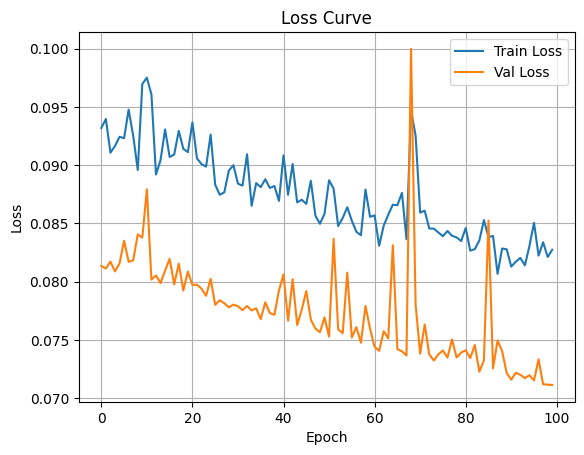

'./training_logs/IR_v2_d1_fixed_bce_20250514_105129/best_model.pth'

In [14]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, log_prefix="IR_v2_d1_fixed_bce")

In [15]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


=== Evaluation Results ===
MAE            : 0.0386
Precision      : 0.6391
Recall         : 0.5336
Fβ (β²=0.3): 0.6112
Mean IoU       : 0.4104
Obj Presence R : 0.9707
Binarize thres.: 0.50
Area fraction  : 0.001000


[INFO] Computed area_frac=0.001055 from GT masks

=== Evaluation Results ===
MAE            : 0.0386
Precision      : 0.5349
Recall         : 0.6326
Fβ (β²=0.3): 0.5546
Mean IoU       : 0.3925
Obj Presence R : 0.9947
Binarize thres.: 0.30
Area fraction  : 0.001055


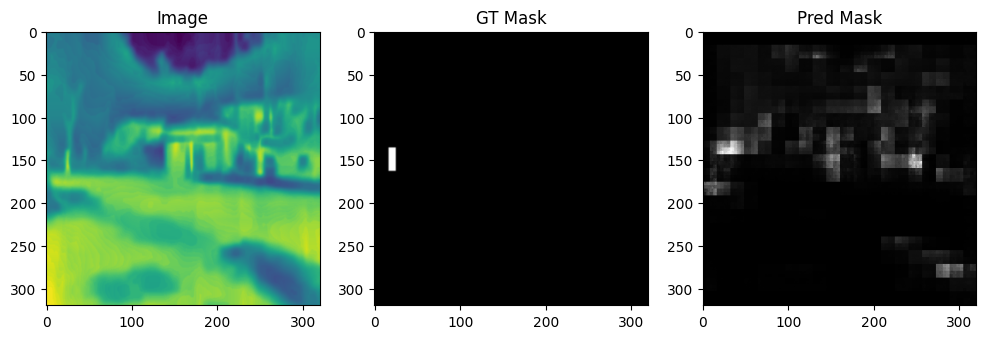

In [16]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.3,
    area_frac=0.001,
    compute_area_frac=True,
    visualize=True
)

### 2 - Military paper IR dataset

In [15]:
# Dataset directories:
image_dirs = [
r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/IR_norm8bit"
]
mask_dirs  = [
r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/IR"
]

# Get loaders
train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(64,16,16)
)

Total images: 2100
Train: 1469, Val: 315, Test: 316


#### Saliency_IR_v1

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.3695 | Val Loss: 0.1887
  Saved best model at epoch 1 (Val Loss: 0.1887)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.1980 | Val Loss: 0.1850
  Saved best model at epoch 2 (Val Loss: 0.1850)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.1918 | Val Loss: 0.1791
  Saved best model at epoch 3 (Val Loss: 0.1791)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.1893 | Val Loss: 0.1767
  Saved best model at epoch 4 (Val Loss: 0.1767)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.1879 | Val Loss: 0.1751
  Saved best model at epoch 5 (Val Loss: 0.1751)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.1864 | Val Loss: 0.1739
  Saved best model at epoch 6 (Val Loss: 0.1739)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.1850 | Val Loss: 0.1744
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1850 | Val Loss: 0.1713
  Saved best model at epoch 8 (Val Loss: 0.1713)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.1832 | Val Loss: 0.1724
Epoch [10/100] | LR: 0.001000 | Trai

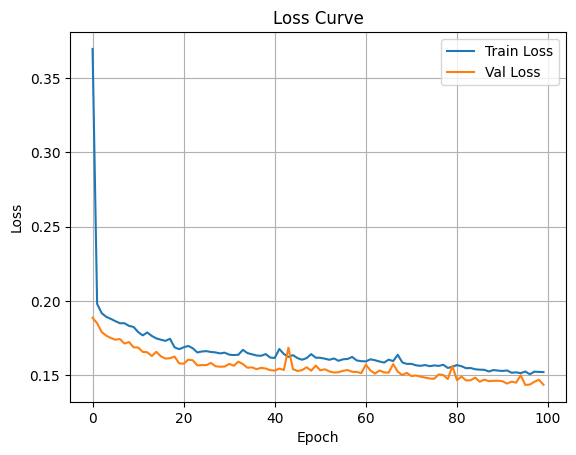


=== Evaluation Results ===
MAE            : 0.0689
Precision      : 0.3046
Recall         : 0.0174
Fβ (β²=0.3): 0.0632
Mean IoU       : 0.0170
Obj Presence R : 0.2848
Binarize thres.: 0.50
Area fraction  : 0.001000


In [16]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, log_prefix="IR_v1_d2_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


#### Saliency_IR_v2

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.7725 | Val Loss: 0.7020
  Saved best model at epoch 1 (Val Loss: 0.7020)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.4249 | Val Loss: 0.2290
  Saved best model at epoch 2 (Val Loss: 0.2290)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.2166 | Val Loss: 0.1904
  Saved best model at epoch 3 (Val Loss: 0.1904)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.1977 | Val Loss: 0.1840
  Saved best model at epoch 4 (Val Loss: 0.1840)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.1946 | Val Loss: 0.1819
  Saved best model at epoch 5 (Val Loss: 0.1819)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.1934 | Val Loss: 0.1814
  Saved best model at epoch 6 (Val Loss: 0.1814)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.1925 | Val Loss: 0.1810
  Saved best model at epoch 7 (Val Loss: 0.1810)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1919 | Val Loss: 0.1800
  Saved best model at epoch 8 (Val Loss: 0.1800)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.1914 | Val 

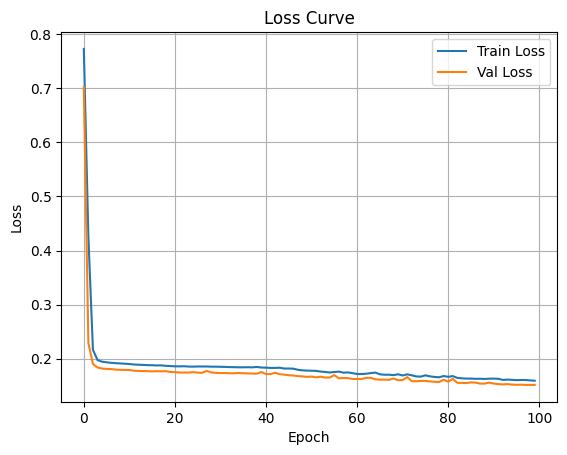


=== Evaluation Results ===
MAE            : 0.0851
Precision      : 0.1248
Recall         : 0.0002
Fβ (β²=0.3): 0.0010
Mean IoU       : 0.0002
Obj Presence R : 0.0000
Binarize thres.: 0.50
Area fraction  : 0.001000


In [ ]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, log_prefix="IR_v2_d2_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


Epoch [1/100] | LR: 0.001000 | Train Loss: 0.1597 | Val Loss: 0.1517
  Saved best model at epoch 1 (Val Loss: 0.1517)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.1588 | Val Loss: 0.1514
  Saved best model at epoch 2 (Val Loss: 0.1514)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.1585 | Val Loss: 0.1513
  Saved best model at epoch 3 (Val Loss: 0.1513)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.1585 | Val Loss: 0.1525
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.1592 | Val Loss: 0.1510
  Saved best model at epoch 5 (Val Loss: 0.1510)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.1592 | Val Loss: 0.1516
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.1585 | Val Loss: 0.1496
  Saved best model at epoch 7 (Val Loss: 0.1496)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1574 | Val Loss: 0.1501
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.1583 | Val Loss: 0.1493
  Saved best model at epoch 9 (Val Loss: 0.1493)
Epoch [10/100] | LR: 0.001000 | Train Loss: 0.1580 | Val Loss: 0.1494
Epoch [11/100] 

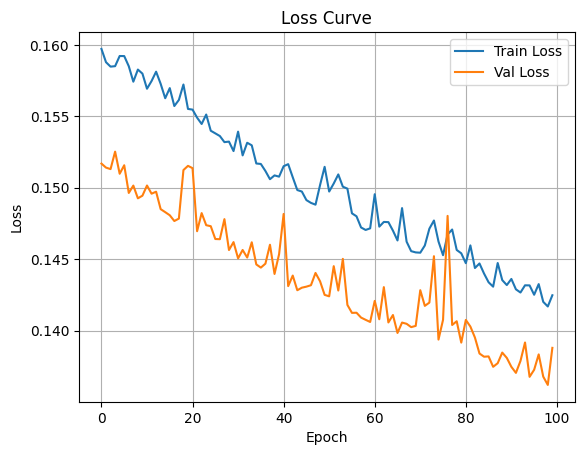

'./training_logs/IR_v2_d2_fixed_bce_20250515_152205/best_model.pth'

In [18]:
train_model(model, train_loader, val_loader, criterion, optimizer, log_prefix="IR_v2_d2_fixed_bce")

In [20]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)



=== Evaluation Results ===
MAE            : 0.0640
Precision      : 0.4008
Recall         : 0.0466
Fβ (β²=0.3): 0.1456
Mean IoU       : 0.0448
Obj Presence R : 0.4905
Binarize thres.: 0.50
Area fraction  : 0.001000


In [19]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.2,
    area_frac=0.001,
    compute_area_frac=True
)

[INFO] Computed area_frac=0.001758 from GT masks

=== Evaluation Results ===
MAE            : 0.0640
Precision      : 0.3566
Recall         : 0.2416
Fβ (β²=0.3): 0.3213
Mean IoU       : 0.1602
Obj Presence R : 0.9365
Binarize thres.: 0.20
Area fraction  : 0.001758


### 3 - IR military scenario dataset

In [10]:
# Dataset directories:
image_dirs = [
r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/images"
]
mask_dirs  = [
r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/saliency_masks"
]

# Get loaders
train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(64,16,16)
)

Total images: 21972
Train: 15380, Val: 3296, Test: 3296


#### Saliency_IR_v1

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.1042 | Val Loss: 0.0585
  Saved best model at epoch 1 (Val Loss: 0.0585)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.0504 | Val Loss: 0.0455
  Saved best model at epoch 2 (Val Loss: 0.0455)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.0448 | Val Loss: 0.0420
  Saved best model at epoch 3 (Val Loss: 0.0420)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.0408 | Val Loss: 0.0411
  Saved best model at epoch 4 (Val Loss: 0.0411)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.0384 | Val Loss: 0.0387
  Saved best model at epoch 5 (Val Loss: 0.0387)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.0359 | Val Loss: 0.0353
  Saved best model at epoch 6 (Val Loss: 0.0353)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.0353 | Val Loss: 0.0336
  Saved best model at epoch 7 (Val Loss: 0.0336)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.0321 | Val Loss: 0.0348
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.0307 | Val Loss: 0.0295
  Saved best model at epoch 9 (Val L

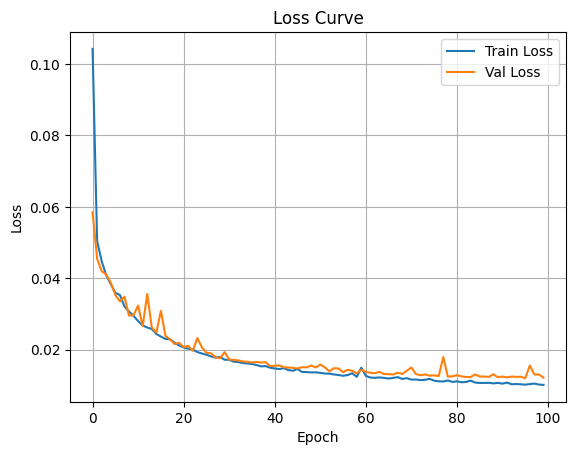


=== Evaluation Results ===
MAE            : 0.0053
Precision      : 0.8426
Recall         : 0.7854
Fβ (β²=0.3): 0.8287
Mean IoU       : 0.8072
Obj Presence R : 0.9947
Binarize thres.: 0.50
Area fraction  : 0.001000


In [11]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, log_prefix="IR_v1_d3_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


#### Saliency_IR_v2

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.1861 | Val Loss: 0.1052
  Saved best model at epoch 1 (Val Loss: 0.1052)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.1007 | Val Loss: 0.0987
  Saved best model at epoch 2 (Val Loss: 0.0987)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.0978 | Val Loss: 0.0973
  Saved best model at epoch 3 (Val Loss: 0.0973)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.0970 | Val Loss: 0.0960
  Saved best model at epoch 4 (Val Loss: 0.0960)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.0822 | Val Loss: 0.0584
  Saved best model at epoch 5 (Val Loss: 0.0584)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.0513 | Val Loss: 0.0473
  Saved best model at epoch 6 (Val Loss: 0.0473)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.0452 | Val Loss: 0.0434
  Saved best model at epoch 7 (Val Loss: 0.0434)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.0424 | Val Loss: 0.0413
  Saved best model at epoch 8 (Val Loss: 0.0413)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.0412 | Val 

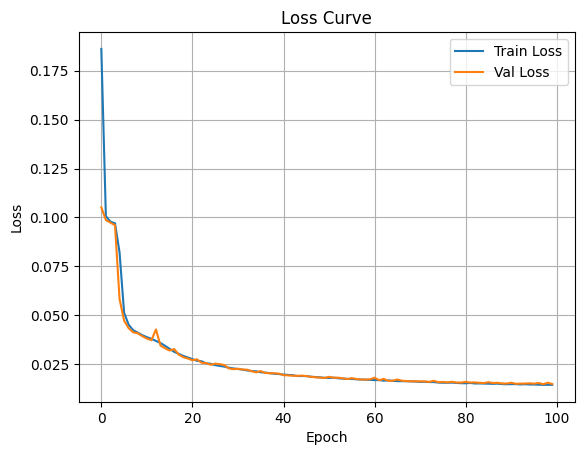


=== Evaluation Results ===
MAE            : 0.0072
Precision      : 0.8245
Recall         : 0.7350
Fβ (β²=0.3): 0.8019
Mean IoU       : 0.7569
Obj Presence R : 0.9820
Binarize thres.: 0.50
Area fraction  : 0.001000


In [12]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, log_prefix="IR_v2_d3_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


###  4 - IR Bridge dataset

In [23]:
# Dataset directories:
image_dirs = [
r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/images"
]
mask_dirs  = [
r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/saliency_masks"
]

# Get loaders
train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(64,16,16)
)

Total images: 1877
Train: 1313, Val: 282, Test: 282


#### Saliency_IR_v1

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.3683 | Val Loss: 0.2433
  Saved best model at epoch 1 (Val Loss: 0.2433)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.2349 | Val Loss: 0.2262
  Saved best model at epoch 2 (Val Loss: 0.2262)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.2254 | Val Loss: 0.2190
  Saved best model at epoch 3 (Val Loss: 0.2190)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.2172 | Val Loss: 0.2119
  Saved best model at epoch 4 (Val Loss: 0.2119)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.2072 | Val Loss: 0.2033
  Saved best model at epoch 5 (Val Loss: 0.2033)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.2044 | Val Loss: 0.2012
  Saved best model at epoch 6 (Val Loss: 0.2012)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.2018 | Val Loss: 0.2002
  Saved best model at epoch 7 (Val Loss: 0.2002)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1996 | Val Loss: 0.1994
  Saved best model at epoch 8 (Val Loss: 0.1994)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.1973 | Val 

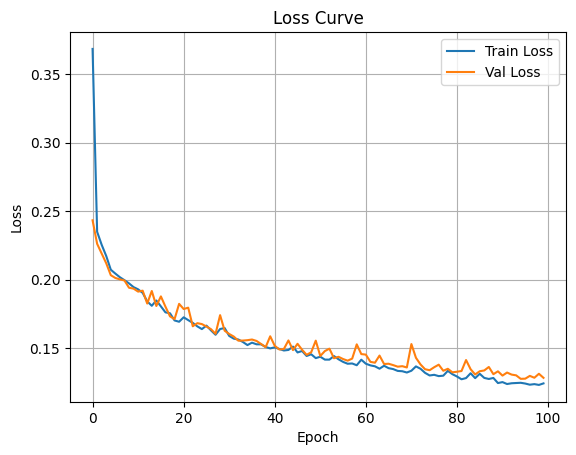


=== Evaluation Results ===
MAE            : 0.0689
Precision      : 0.7583
Recall         : 0.6157
Fβ (β²=0.3): 0.7198
Mean IoU       : 0.5097
Obj Presence R : 1.0000
Binarize thres.: 0.50
Area fraction  : 0.001000


In [24]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, log_prefix="IR_v1_d4_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


#### Saliency_IR_v2

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.7261 | Val Loss: 0.6232
  Saved best model at epoch 1 (Val Loss: 0.6232)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.5174 | Val Loss: 0.4112
  Saved best model at epoch 2 (Val Loss: 0.4112)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.3645 | Val Loss: 0.3063
  Saved best model at epoch 3 (Val Loss: 0.3063)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.2803 | Val Loss: 0.2453
  Saved best model at epoch 4 (Val Loss: 0.2453)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.2443 | Val Loss: 0.2359
  Saved best model at epoch 5 (Val Loss: 0.2359)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.2398 | Val Loss: 0.2328
  Saved best model at epoch 6 (Val Loss: 0.2328)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.2353 | Val Loss: 0.2316
  Saved best model at epoch 7 (Val Loss: 0.2316)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.2301 | Val Loss: 0.2259
  Saved best model at epoch 8 (Val Loss: 0.2259)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.2247 | Val 

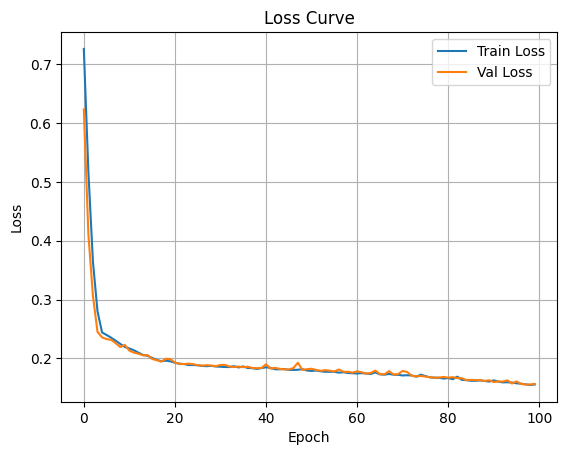


=== Evaluation Results ===
MAE            : 0.0855
Precision      : 0.7392
Recall         : 0.4484
Fβ (β²=0.3): 0.6430
Mean IoU       : 0.3817
Obj Presence R : 0.9929
Binarize thres.: 0.50
Area fraction  : 0.001000


In [25]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, log_prefix="IR_v2_d4_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


###  5 - IR HIT-UAV dataset

In [26]:
# Dataset directories:
image_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/val"
]
mask_dirs  = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/val" 
]

# Get loaders
train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(64,16,16)
)

Total images: 2866
Train: 2006, Val: 430, Test: 430


#### Saliency_IR_v1

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.2712 | Val Loss: 0.1545
  Saved best model at epoch 1 (Val Loss: 0.1545)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.1512 | Val Loss: 0.1468
  Saved best model at epoch 2 (Val Loss: 0.1468)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.1443 | Val Loss: 0.1413
  Saved best model at epoch 3 (Val Loss: 0.1413)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.1406 | Val Loss: 0.1391
  Saved best model at epoch 4 (Val Loss: 0.1391)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.1356 | Val Loss: 0.1285
  Saved best model at epoch 5 (Val Loss: 0.1285)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.1306 | Val Loss: 0.1250
  Saved best model at epoch 6 (Val Loss: 0.1250)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.1247 | Val Loss: 0.1457
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1252 | Val Loss: 0.1244
  Saved best model at epoch 8 (Val Loss: 0.1244)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.1191 | Val Loss: 0.1217
  Saved best model at epoch 9 (Val L

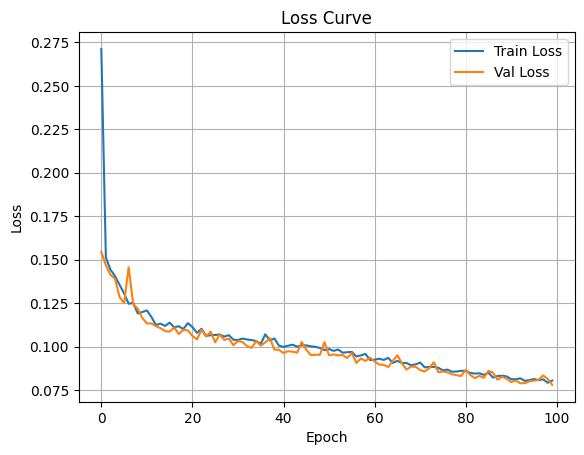


=== Evaluation Results ===
MAE            : 0.0383
Precision      : 0.6582
Recall         : 0.3757
Fβ (β²=0.3): 0.5609
Mean IoU       : 0.2996
Obj Presence R : 0.9645
Binarize thres.: 0.50
Area fraction  : 0.001000


In [27]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, log_prefix="IR_v1_d5_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


#### Saliency_IR_v2

Epoch [1/100] | LR: 0.001000 | Train Loss: 0.4719 | Val Loss: 0.3361
  Saved best model at epoch 1 (Val Loss: 0.3361)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.2249 | Val Loss: 0.1692
  Saved best model at epoch 2 (Val Loss: 0.1692)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.1600 | Val Loss: 0.1528
  Saved best model at epoch 3 (Val Loss: 0.1528)
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.1503 | Val Loss: 0.1475
  Saved best model at epoch 4 (Val Loss: 0.1475)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.1486 | Val Loss: 0.1442
  Saved best model at epoch 5 (Val Loss: 0.1442)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.1447 | Val Loss: 0.1435
  Saved best model at epoch 6 (Val Loss: 0.1435)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.1435 | Val Loss: 0.1412
  Saved best model at epoch 7 (Val Loss: 0.1412)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.1426 | Val Loss: 0.1397
  Saved best model at epoch 8 (Val Loss: 0.1397)
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.1411 | Val 

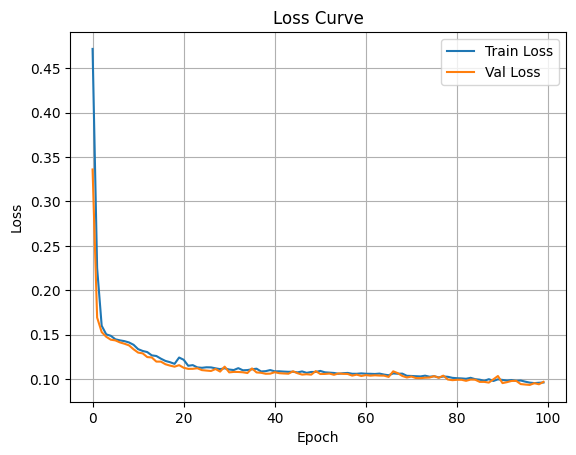


=== Evaluation Results ===
MAE            : 0.0596
Precision      : 0.0000
Recall         : 0.0000
Fβ (β²=0.3): 0.0000
Mean IoU       : 0.0000
Obj Presence R : 0.0000
Binarize thres.: 0.50
Area fraction  : 0.001000


In [28]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, log_prefix="IR_v2_d5_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)

In [29]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.2,
    area_frac=0.001,
    compute_area_frac=False
)


=== Evaluation Results ===
MAE            : 0.0596
Precision      : 0.2700
Recall         : 0.5202
Fβ (β²=0.3): 0.3037
Mean IoU       : 0.1914
Obj Presence R : 0.9953
Binarize thres.: 0.20
Area fraction  : 0.001000


###  6 - IR combined dataset

In [13]:
# List of folders
image_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/images",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/images",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/images/val",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/images/RGB",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/images/RGB"
]

mask_dirs = [
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Actual scenario/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/Bridge data/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/test",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/train",
    r"/home/deepaksr/project/Saliency_datasets/IR_only/hit-uav/saliency_masks/val",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/simulated/saliency_masks",
    r"/home/deepaksr/project/Saliency_datasets/co-reg/paper_dataset/Saliency_map/RGB"
]

# Get loaders
train_loader, val_loader, test_loader = get_saliency_loaders(
    image_dirs, mask_dirs,
    input_size=(320,320),
    split_ratio=(0.7,0.15,0.15),
    batch_sizes=(64,16,16)
)

Total images: 31566
Train: 22096, Val: 4735, Test: 4735


#### Saliency_IR_v1

In [ ]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v1().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, log_prefix="IR_v1_d6_combined_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


Epoch [1/100] | LR: 0.001000 | Train Loss: 0.1285 | Val Loss: 0.1060
  Saved best model at epoch 1 (Val Loss: 0.1060)
Epoch [2/100] | LR: 0.001000 | Train Loss: 0.1036 | Val Loss: 0.0981
  Saved best model at epoch 2 (Val Loss: 0.0981)
Epoch [3/100] | LR: 0.001000 | Train Loss: 0.0936 | Val Loss: 0.0987
Epoch [4/100] | LR: 0.001000 | Train Loss: 0.0884 | Val Loss: 0.0840
  Saved best model at epoch 4 (Val Loss: 0.0840)
Epoch [5/100] | LR: 0.001000 | Train Loss: 0.0826 | Val Loss: 0.0788
  Saved best model at epoch 5 (Val Loss: 0.0788)
Epoch [6/100] | LR: 0.001000 | Train Loss: 0.0766 | Val Loss: 0.0737
  Saved best model at epoch 6 (Val Loss: 0.0737)
Epoch [7/100] | LR: 0.001000 | Train Loss: 0.0719 | Val Loss: 0.0684
  Saved best model at epoch 7 (Val Loss: 0.0684)
Epoch [8/100] | LR: 0.001000 | Train Loss: 0.0682 | Val Loss: 0.0687
Epoch [9/100] | LR: 0.001000 | Train Loss: 0.0654 | Val Loss: 0.0636
  Saved best model at epoch 9 (Val Loss: 0.0636)
Epoch [10/100] | LR: 0.001000 | Trai

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v1().to(device)

In [11]:
checkpoint = torch.load('/home/deepaksr/project/Project_files_2/training_logs/IR_v1_d6_combined_fixed_bce_20250518_182701/best_model.pth', map_location=device)
model.load_state_dict(checkpoint)
model.eval()

/tmp/ipykernel_3089016/851145921.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/deepaksr/project/Project_files_2/training_logs/IR_v1_d6_c

Saliency_IR_v1(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)

In [14]:
metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


=== Evaluation Results ===
MAE            : 0.0179
Precision      : 0.7821
Recall         : 0.6562
Fβ (β²=0.3): 0.7489
Mean IoU       : 0.6483
Obj Presence R : 0.9769
Binarize thres.: 0.50
Area fraction  : 0.001000


#### Saliency_IR_v2

Epoch [1/25] | LR: 0.001000 | Train Loss: 0.2120 | Val Loss: 0.1308
  Saved best model at epoch 1 (Val Loss: 0.1308)
Epoch [2/25] | LR: 0.001000 | Train Loss: 0.1278 | Val Loss: 0.1252
  Saved best model at epoch 2 (Val Loss: 0.1252)
Epoch [3/25] | LR: 0.001000 | Train Loss: 0.1192 | Val Loss: 0.1079
  Saved best model at epoch 3 (Val Loss: 0.1079)
Epoch [4/25] | LR: 0.001000 | Train Loss: 0.1047 | Val Loss: 0.0994
  Saved best model at epoch 4 (Val Loss: 0.0994)
Epoch [5/25] | LR: 0.001000 | Train Loss: 0.0991 | Val Loss: 0.0954
  Saved best model at epoch 5 (Val Loss: 0.0954)
Epoch [6/25] | LR: 0.001000 | Train Loss: 0.0961 | Val Loss: 0.0926
  Saved best model at epoch 6 (Val Loss: 0.0926)
Epoch [7/25] | LR: 0.001000 | Train Loss: 0.0934 | Val Loss: 0.0910
  Saved best model at epoch 7 (Val Loss: 0.0910)
Epoch [8/25] | LR: 0.001000 | Train Loss: 0.0916 | Val Loss: 0.0890
  Saved best model at epoch 8 (Val Loss: 0.0890)
Epoch [9/25] | LR: 0.001000 | Train Loss: 0.0896 | Val Loss: 0.0

OSError: [Errno 28] No space left on device

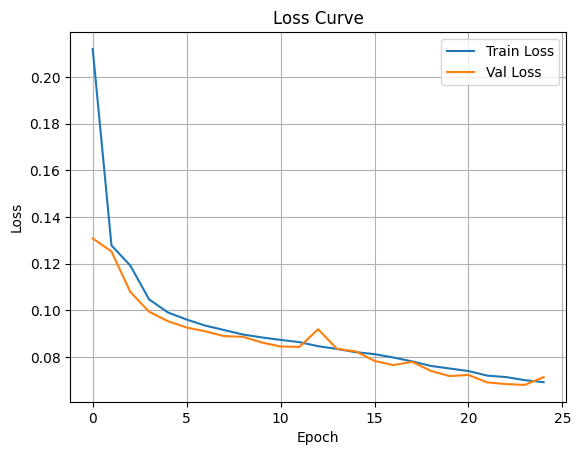

In [15]:
# Training and eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Saliency_IR_v2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, log_prefix="IR_v2_d6_combined_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)

In [16]:
#train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, log_prefix="IR_v2_d6_combined_fixed_bce")

metrics = evaluate_model(
    model, test_loader, device,
    bin_thresh=0.5,
    area_frac=0.001,
    compute_area_frac=False
)


=== Evaluation Results ===
MAE            : 0.0440
Precision      : 0.5733
Recall         : 0.4540
Fβ (β²=0.3): 0.5405
Mean IoU       : 0.4229
Obj Presence R : 0.8495
Binarize thres.: 0.50
Area fraction  : 0.001000


# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load model for compiled data
MODEL_PATH = "path/to/best_model.pth"
model = load_model(Saliency_IR_v1, MODEL_PATH, DEVICE)